In [18]:
import json
with open('data/matches.json', 'r') as infile:
    matches = json.load(infile)
matches[0]

{'crewmates': ['Player 3',
  'Player 9',
  'Player 17',
  'Player 16',
  'Player 6',
  'Player 14',
  'Player 1',
  'Player 4'],
 'impostors': ['Player 2', 'Player 5'],
 'map': 'MIRA HQ',
 'confirm_ejects': False,
 'emergency_meetings': 3,
 'emergency_cooldown': 30,
 'discussion_time': 15,
 'voting_time': 75,
 'anonymous_votes': True,
 'player_speed': 1.25,
 'crewmate_vision': 4.5,
 'impostor_vision': 4.5,
 'kill_cooldown': 25.0,
 'kill_distance': 'Medium',
 'visual_tasks': True,
 'task_bar_updates': 'Always',
 'common_tasks': 2,
 'long_tasks': 1,
 'short_tasks': 1,
 'match_winner': 'crewmates'}

In [2]:
import numpy as np

In [3]:
# Converting the data to something the model can use
# My thinking here is basically onehot encode the players
# With two rows, the first will be active in crew indexes,
# the second will be active in impostor indexes.
# The third row can be used for game settings
class PlayerEncoder:
    def __init__(self):
        self._encodings = {}
        self.pcount_ = 0
        
    def fit(self, player_arrs):
        nextval = self.pcount_
        for arr in player_arrs:
            for player in arr:
                if player not in self._encodings.keys():
                    self._encodings[player] = nextval
                    nextval += 1
        self.pcount_ = nextval
                    
    def transform(self, player_arrs):
        result = np.zeros((len(player_arrs), self.pcount_), dtype=int)
        for i,arr in enumerate(player_arrs):
            indexes = [self._encodings[p] for p in arr]
            result[i, indexes] = 1
        return result
    
    def fit_transform(self, player_arrs):
        self.fit(player_arrs)
        return self.transform(player_arrs)

In [19]:
enc = PlayerEncoder()
plist = matches[0]['crewmates'] + matches[0]['impostors']
enc.fit([plist])

In [20]:
enc._encodings

{'Player 3': 0,
 'Player 9': 1,
 'Player 17': 2,
 'Player 16': 3,
 'Player 6': 4,
 'Player 14': 5,
 'Player 1': 6,
 'Player 4': 7,
 'Player 2': 8,
 'Player 5': 9}

In [21]:
enc.transform([matches[0]['crewmates'], matches[0]['impostors']])

array([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]])

In [22]:
# Rather than replace what I wrote above for the input shape,
# the three rows I described should really be flattened for
# real input. Though conceptually it will probably help to
# think of them as three individual components
from sklearn.preprocessing import OneHotEncoder

# Fit the player encoder
penc = PlayerEncoder()
penc.fit([m['crewmates'] + m['impostors'] for m in matches])
# Fit the map encoder
# For now just hard-code the maps
menc = OneHotEncoder(sparse=False)
menc.fit([['The Skeld'], ['MIRA HQ'], ['Polus'], ['Airship']])
# May as well include the winner encoder here as well
wenc = OneHotEncoder(sparse=False)
wenc.fit([['crewmates'], ['impostors']])

# Create dicts for string settings
kill_distance = {
    'Short': 1,
    'Medium': 2,
    'Long': 3
}
task_bar_updates = {
    'Always': 2,
    'Meetings': 1,
    'Never': 0
}

# Function to convert a single match
def convert_match_result(match):
    # Do conversions for the things that need converting
    crewmates = list(penc.transform([match['crewmates']])[0])
    impostors = list(penc.transform([match['impostors']])[0])
    map_played = list(menc.transform([[match['map']]])[0])
    
    inputs = np.array(crewmates + impostors + map_played + [
        np.sum(crewmates), # No. crewmates
        np.sum(impostors), # No. impostors
        match['confirm_ejects'],
        match['emergency_meetings'],
        match['emergency_cooldown'],
        match['discussion_time'],
        match['voting_time'],
        match['anonymous_votes'],
        match['player_speed'],
        match['crewmate_vision'],
        match['impostor_vision'],
        match['kill_cooldown'],
        kill_distance[match['kill_distance']],
        match['visual_tasks'],
        task_bar_updates[match['task_bar_updates']],
        match['common_tasks'],
        match['long_tasks'],
        match['short_tasks']
    ])
    # Convert winners
    winner = wenc.transform([[match['match_winner']]])[0]
    
    return (inputs, winner)

convert_match_result(matches[0])

(array([ 1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  1.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  1.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  8.  ,
         2.  ,  0.  ,  3.  , 30.  , 15.  , 75.  ,  1.  ,  1.25,  4.5 ,
         4.5 , 25.  ,  2.  ,  1.  ,  2.  ,  2.  ,  1.  ,  1.  ]),
 array([1., 0.]))

In [23]:
inputs = []
targets = []
for m in matches:
    result = convert_match_result(m)
    inputs.append(result[0])
    targets.append(result[1])
inputs = np.array(inputs)
targets = np.array(targets)
inputs.shape, targets.shape

((10000, 62), (10000, 2))

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [33]:
model = Sequential()
# This might be a bit unconventional, but it's something
# I want to try. Use the number of players to determine
# the output shape of the first couple of layers
pcount = penc.pcount_
mcount = len(menc.categories_[0])
model.add(Dense(pcount * pcount * mcount, input_shape=inputs[0].shape, activation='relu'))
# You know what, while I'm at it, lets just go ham with
# automatically generating layers
# I tried a couple of things, I like //3 the best so far
layer_size = pcount * pcount
while layer_size > 2:
    model.add(Dense(layer_size, activation='relu'))
    layer_size //= 3
    
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [30]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 1600)              100800    
_________________________________________________________________
dense_27 (Dense)             (None, 400)               640400    
_________________________________________________________________
dense_28 (Dense)             (None, 133)               53333     
_________________________________________________________________
dense_29 (Dense)             (None, 44)                5896      
_________________________________________________________________
dense_30 (Dense)             (None, 14)                630       
_________________________________________________________________
dense_31 (Dense)             (None, 4)                 60        
_________________________________________________________________
dense_32 (Dense)             (None, 2)                

In [36]:
from tensorflow.keras.callbacks import EarlyStopping
stop = EarlyStopping(monitor='val_acc', patience=5)

history = model.fit(
    x = inputs,
    y = targets,
    batch_size = 32,
    epochs = 100,
    validation_split = 0.2,
    callbacks = [stop]
)

Epoch 1/100
250/250 [==============================] - 2s 6ms/step - loss: 0.3825 - acc: 0.8224 - val_loss: 0.4108 - val_acc: 0.8010
Epoch 2/100
250/250 [==============================] - 2s 6ms/step - loss: 0.3799 - acc: 0.8254 - val_loss: 0.4111 - val_acc: 0.8100
Epoch 3/100
250/250 [==============================] - 2s 6ms/step - loss: 0.3800 - acc: 0.8245 - val_loss: 0.4042 - val_acc: 0.8055
Epoch 4/100
250/250 [==============================] - 1s 6ms/step - loss: 0.3738 - acc: 0.8270 - val_loss: 0.4165 - val_acc: 0.8100
Epoch 5/100
250/250 [==============================] - 1s 6ms/step - loss: 0.3734 - acc: 0.8298 - val_loss: 0.4064 - val_acc: 0.7995
Epoch 6/100
250/250 [==============================] - 2s 6ms/step - loss: 0.3756 - acc: 0.8292 - val_loss: 0.4498 - val_acc: 0.7880
Epoch 7/100
250/250 [==============================] - 2s 6ms/step - loss: 0.3756 - acc: 0.8235 - val_loss: 0.4157 - val_acc: 0.8020
Epoch 8/100
250/250 [==============================] - 2s 6ms/step - 

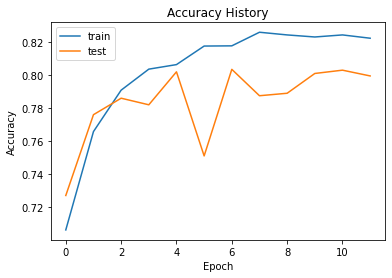

In [35]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.show()

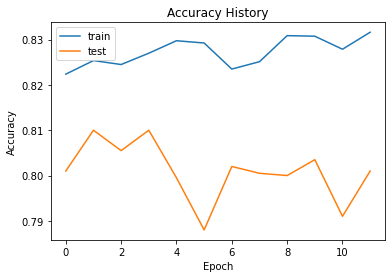

In [37]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.show()

In [38]:
model.save('models/rngenerated')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/rngenerated\assets
